In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
from copy import deepcopy
from preprocessing import Preprocess
import pickle
import warnings

warnings.filterwarnings("ignore")

In [2]:
import seaborn as sns
from copy import deepcopy
from utils import *

import itertools
import json
import os

#For e-autoMFIS, we import all of them.
from autoMFIS_test import autoMFIS
import numpy as np
import scipy.io
from reweight import Reweight
from fuzzyfication import Fuzzification
from defuzzification import Defuzzification
import matplotlib.pyplot as plt
from predict import predict, predict_pattern



def convert_object_to_float(data,datanames):
    
    for name in datanames:
        dname = data[name].values.astype('str')
        dname = [new_value.replace(',','.') for new_value in dname]
        data[name] = dname
        data[name] = data[name].astype(float)
    return data

##Assertion for ensemble rules
#Somehow, when appending rules, ensemble_rules[:,1] has a erroneous form. This part seems to normalize it.

#This module correct this error. Also, we are going to use some assertion to check if rules contains the same antecedents.
def correct_bug(ensemble_rules,max_rulesize=0):
    correct_rule = []
    d_stacked_rules = []
    new_ensemble_rules = np.zeros(shape=ensemble_rules.shape, dtype=object)


    for  n_times in range(ensemble_rules.shape[1]):
        t_rules = ensemble_rules[:,n_times]
        correct_rule = []
        d_stacked_rules = []
        k = 0
        for rule in t_rules:
            #print(rule)
            #print(len(rule))
            #Check if there's a rule bigger than max_rulesize + 1 (#antecedents + #consequent)
            if len(rule) > max_rulesize + 1:
                #print(rule)
                for i in rule:
                    #k += 1
                    if isinstance(i,tuple):
                        #print(i)
                        correct_rule.append(i)
                    else:
                        if len(correct_rule) == 0:
                            #print(i)
                            pass
                            #d_stacked_rules.append(i)
                        else:
                            #print(correct_rule)
                            new_ensemble_rules[k,n_times] = correct_rule
                            k += 1
                            #d_stacked_rules.append(correct_rule)
                            correct_rule = []
                            #d_stacked_rules.append(i)
            else:
                new_ensemble_rules[k,n_times] = rule
                k += 1
                #d_stacked_rules.append(rule)
            
        #new_ensemble_rules[:,i] = np.array(d_stacked_rules)

    return new_ensemble_rules

def remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents):
    t_rules = deepcopy(new_ensemble_rules[:,0])
    no_duplicated_ensemble = np.zeros(new_ensemble_rules.shape,dtype=object)
    no_duplicated_prem_terms = np.zeros(ensemble_prem_terms.shape)
    no_duplicated_antecedents = np.zeros(ensemble_antecedents.shape,dtype=object)
    new_t_rules = None

    k = 0
    j = 0
    for rule in t_rules:
        if new_t_rules is None:
            new_t_rules = [rule]
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1

        elif not check_duplicate_rules(rule,new_t_rules):
            new_t_rules.append(rule)
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1
        j += 1

    new_rules = deepcopy(no_duplicated_ensemble[:k,:])
    new_prem_terms = deepcopy(no_duplicated_prem_terms[:k,:])
    new_antecedents = deepcopy(no_duplicated_antecedents[:k,:])

    return new_rules, new_prem_terms, new_antecedents



In [3]:
#Rule Object structure
class rule_object():
    def __init__(self,complete_rules,prem_terms,rules,wd_,index):
        self.complete_rules = complete_rules
        self.prem_terms = prem_terms
        self.rules = rules
        self.index = index
        self.wd_ = wd_

In [4]:
def pp(initial_values, lags_used = [], ndata=[''], data=[], in_sample=[], out_sample=[], agg_training=None,h_prev=0,n_attempt=0,wd_=[],ensemble_antecedents=[],ensemble_rules=[],not_used_lag = False, filepath='',lim=0, fig_axis=[3,2]):
    '''
    Module to time series forecasting. It uses multi-stepping in order to evaluate the model.
    INPUTS:
    \n - Fuzzyfy: Object containing informations about Fuzzification.
    \n - lags_used: If not_used_lags is true, masks series that isn't in list.
    \n - num_groups: Number of fuzzy sets.
    \n - ndata: name of data (e.g. column header)
    \n - data: data of the problem
    \n - in_sample: in_sample set of data
    \n - out_sample: out_sample set of data
    \n - lag:
    \n - mf_params: Membership function parameters
    \n - agg_training: Aggregation terms in training set. Used to simplify deffuzification of training set.
    \n - yp_lagged
    \n - h_prev:
    #TODO - Continue this list

    VARIABLES:
    \n - y_predict_: Training set prediction
    \n - yp_totest: Input pattern to evaluate prediction
    \n - yt_totest: Output data, for each horizon and serie.
    '''
    

    print(f'Shape of ensemble rules is {ensemble_rules.shape}')


    defuzz = Defuzzification(model.mf_params,num_series)
    if agg_training is not None:
        y_predict_ = defuzz.run(defuzz_method,agg_training)

    yp_totest = initial_values
    yt_totest = np.zeros((h_prev,num_series))

    #Prediction - Multi-step
    for h_p in range(h_prev):

        #Check activated terms.
        mX_values_in = np.zeros((1,model.mf_params.shape[0],yp_totest.shape[1]))

        antecedents_activated = []
        it = 0
        for i in range(num_series):
            mf_params = model.mf_params[:,i]
            for j in range(lag):

                mX, _ = Fuzzyfy.fuzzify(np.array([yp_totest[0,i*lag+j]]),mf_params,num_groups=num_groups)
                mX_values_in[:,:,i*lag+j] = mX


                idx_nonzero = np.where(mX[0,:] > 0)
                idx_nonzero = idx_nonzero[0]

                if not_used_lag:
                    for k in range(idx_nonzero.shape[0]):
                        if j in lags_used[i]:
                            antecedents_activated.append((it,idx_nonzero[k]))
                        else:
                            pass
                    it += 1
                
                else:
                    for k in range(idx_nonzero.shape[0]):
                        antecedents_activated.append((i*lag+j,idx_nonzero[k]))

        '''
        if not_used_lag:
            mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


        prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
        '''
        rules_idx = []
        check_idx = 0
        #Checking for every rule in dataset if it's activated
        #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
        for n_rule in ensemble_antecedents:
            #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
            if test(n_rule,antecedents_activated):
                rules_idx.append(check_idx)
            check_idx += 1
            
        prem_activated = np.zeros((ensemble_antecedents.shape[0],))
        for i in rules_idx:
            prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
        
        agg_test = np.zeros((wd_.shape))
        for i in range(num_series):
            for j in rules_idx:
                rule = ensemble_rules[j,i]
                consequent = rule[-1]
                agg_test[j,consequent[1],i] = prem_activated[j,]
                

        weight_agg = np.multiply(agg_test,wd_)
        weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))
        for i in range(weight_.shape[1]):
            weight_[:,i] = weight_agg[:,:,i].max(axis=0)

        w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
        
        #Defuzzification in fact
        y_pred = defuzz.run(defuzz_method,w_todefuzz,show=False)
        
        #Store predicted value into yt_totest.
        yt_totest[h_p,:] = y_pred
        
        #Last step, we use the predicted output to compose input data.
        y_temp = np.zeros(yp_totest.shape)
        assert y_temp.shape == yp_totest.shape
        y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
        for ii in range(num_series):
            #print(yp_totest[0,ii*lag])
            #print(y_pred[0][ii])
            #yp_totest[0,ii*lag] = y_pred[0][ii]
            y_temp[0,ii*lag] = y_pred[0][ii]
            #print(yp_totest[0,yp_totest.shape[1]-1])
        yp_totest = y_temp

    k = 1
    for i in range(num_series):
        plt.subplot(fig_axis[0],fig_axis[1],k)
        plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
        plt.plot(yt_totest[:,i],color='blue')
        plt.plot(out_sample[:,i],color='red')
        plt.legend(['Predicted','Target'])
        plt.xlabel('Time(h)',fontsize=15)
        plt.ylabel('Value',fontsize=15)
        print(rrse(yt_totest[:,i],out_sample[:,i]))
        k += 1

    return yp_totest, yt_totest

In [5]:
with open ('results.traffic','rb') as f:
    predicted_values = pickle.load(f)

In [6]:
#Loading data
dataset = pd.read_csv('traffic.txt',header=None)

In [7]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,852,853,854,855,856,857,858,859,860,861
0,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,0.0518,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,0.0409,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,0.0386,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,0.0360,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


In [8]:
#Basic informations 

num_predictors = 1
num_input = 12
lag = 24
lag_notused = np.array([[4,5],[4,5],[4],[4,5]])
not_used_lag = False

h_test = int(0.2*dataset.shape[0]) #Changed test set for 20% of dataset (3508 values)
h_val = 168
h_train = 24*7*12
#Actually, lag stands for all inputs for each serie. Example, lag = 2 uses s(t) and s(t-1) to predict s(t+1)
diff_series = False
detrend_series = False

In [9]:
#bin_values = 12; #Representação da binarização do tempo.
#num_series = data_.shape[1]  #Numero de series do problema, extraído dos dados
num_series = 70
max_rulesize = 3 #Max numbers of premises rules.
min_activation = 0.6 #Minimum activation

#####Definicao de funcoes######
#detrend_method = ''
#bin_method = ''

fuzzy_method = 'mfdef_cluster'
num_groups = 9

defuzz_method = 'height'

ensemble_rules = None

total_number = num_series*lag


filepath = 'results V1'



In [10]:
#We are going to split between training, validation and test set.
#Training set: 2 months of data (168*60) + lag
#Validation set: 168 steps (1 week)
#Test set: 168 steps (1 week)
a = dataset.shape[0]
training_data = dataset[a - h_train - lag - 1 - h_val - h_test:a-h_test]
test_data = dataset[a - h_test:a]

training_values = training_data.values

In [11]:
h_train_2 = a - h_test - h_val
all_data_2 = dataset[lag:] 
training_data_2 = dataset[lag:lag+h_train_2]
test_data_2 = dataset[a - h_test:a]

data_ = training_data_2.values

In [12]:
training_data.shape

(2209, 862)

In [13]:
test_data.shape

(3508, 862)

In [14]:
#data = data1[:,[0, 61, 147, 241]]

#data_ = training_values[:,:4]
#data_ = training_values[:,[0, 61, 147, 241]]
#data_ = training_values[:,0:1]
#data_ = training_values[:,[0,61]]

In [15]:
#data_.shape

In [16]:
def preprocess_external(data_, h_val, num_series, training_set, test_set, lag, all_data=None):
    # preprocess_data = Preprocess(data_,h_prev=h_val,num_series=num_series)
    #For training set
    preprocess_data = Preprocess(data_,h_prev=h_val, lag=lag, num_series=num_series)
    training_set, val_set = preprocess_data.split_data()
    yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = training_set, lag = lag)

    if all_data is None:
        all_data = np.concatenate((training_set, test_set))
    #For all set. This will be useful for initial values of prediction
    all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = all_data, lag = lag)

    # assert val_set.shape[0] == h_val
    # assert yp_lagged.shape[0] == h_train
    # assert yt.shape[0] == h_train

    return preprocess_data, training_set, val_set, yt, yp, yp_lagged, all_yt, all_yp, all_lagged

In [17]:
def fuzzy_external(fuzzy_method, num_series, training_set, num_groups, yp_lagged, lag):
    ###############Fuzzificacao

    Fuzzyfy = Fuzzification(fuzzy_method)

    #Lembrete: 
    #axis 0 - Registros da série
    #axis 1 - Valor de pertinência ao conjunto Fuzzy
    #axis 2 - Numero de séries

    first_time = True
    for n in range(num_series):
        # print(f'Serie {n} fuzzification')
        _, mf_params = Fuzzyfy.fuzzify(training_set[:,n],np.array([]),num_groups=num_groups)
        mX, _ = Fuzzyfy.fuzzify(yp[:,n],mf_params,num_groups=num_groups)
        mY, _ = Fuzzyfy.fuzzify(yt[:,n],mf_params,num_groups=num_groups)
        if first_time:
            mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
            mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
            mf_params_ = np.ndarray([mf_params.shape[0],num_series])
            first_time = False
        mX_[:,:,n] = mX
        mY_[:,:,n] = mY
        mf_params_[:,n] = mf_params.ravel()
        #print(mf_params)
        #print(mX.shape)

    print('Creating for lag values')
    mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
    for i in range(num_series):
        # print(f'Serie {i}')
        mf_params = mf_params_[:,i]
        for j in range(lag):
            mX, _ = Fuzzyfy.fuzzify(yp_lagged[:,i*lag+j],mf_params,num_groups=num_groups)
            mX_lagged_[:,:,i*lag+j] = mX
            #print(i*lag+j)


    #mX_lagged_[:,:,not_select_subsample] = 0

    #print(mX_lagged_[:,:,not_select_subsample])
    ############## Formulacao
    if not_used_lag:
        new_mX, lags_used = remove_lags(mX_lagged_,lag_notused,num_series,lag)
    else:
        new_mX = mX_lagged_

    return Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_

In [18]:

#preprocess_data, training_set, val_set, yt, yp, yp_lagged, all_yt, all_yp, all_lagged = preprocess_external(data_,h_val,num_series, training_set, lag)

#Fuzzyfy, mX_, mY_, mf_params_, mX_laged_ = fuzzy_external(fuzzy_method, num_series, training_set, num_groups, yp_lagged, lag)

In [19]:
# with open ('results.traffic','rb') as f:
#     predicted_values = pickle.load(f)

# #predicted_values = np.zeros((h_test, dataset.shape[1]))

# for n_s in range(35,75):
#     print(f'Begin serie {n_s}')
#     print('='*89)
#     train_values = training_values[:,n_s:n_s+1]
#     test_values = test_data.values[:,n_s:n_s+1]

#     preprocess_data, training_set, val_set, yt, yp, yp_lagged, all_yt, all_yp, all_lagged = preprocess_external(train_values,h_val,num_series, train_values, test_values, lag)

#     Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_ = fuzzy_external(fuzzy_method, num_series, training_set, num_groups, yp_lagged, lag)

#     new_mX = mX_lagged_
#     #Initialization of model

#     manual_pattern = 7

#     #Creation a list of rule object. 
#     list_rules = [rule_object(None,None,None,None,i) for i in range(7)]

#     for n_pattern in range(manual_pattern):

#         min_error = 300.0

#         #print('='*89)
#         #print(f'Starting Pattern {n_pattern}')
#         #print('='*89)
#         #Select a sample pattern for our problem. In that case, we apply a manual pattern on dataset
#         t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
#         t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
        
#         t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]

        
#         yp1 = deepcopy(yp[t_lagged,:])
        
#         yt1 = deepcopy(yt[t_lagged,:])
        
#         yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

#         in_sample = training_set[t,:]
#         #plt.figure()
#         #plt.plot(in_sample)
#         #plt.show()
#         out_sample = val_set[t_val,:]
        
#         #Iintial values for prediction
#         initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

#         #Always checking if initial values are correct by asserting it's target
#         #assert (all_yt[yp_lagged.shape[0] + t_val[0],:] == out_sample[0,:]).all(), 'Target mismatch. Verify initial values lag.'

#         #print(f'Shape of in-sample is {in_sample.shape[0]}')
#         #assert in_sample.shape[0] == h_train//7
#         #print(f'Shape of lagged data is {yp_lagged1.shape[0]}')
#         #assert yp_lagged1.shape[0] == h_train//manual_pattern
#         #print(f'Shape of validation set is {out_sample.shape[0]}')
#         #assert out_sample.shape[0] == h_val//manual_pattern
#         #data1 = deepcopy(data_[t[len(t)-len(t_lagged):],:])
#         #in_sample = data1[:data1.shape[0]-h_prev,:]
#         #out_sample = data1[data1.shape[0]-h_prev:,:]
#         #ensemble_rules = list_rules[n_pattern].complete_rules 
#         #ensemble_prem_terms = list_rules[n_pattern].prem_terms
#         #ensemble_antecedents = list_rules[n_pattern].rules

#         #Concatenate rules
#         for i in range(num_predictors):
#             not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
#             n_mX = deepcopy(new_mX)
#             n_mX[:,:,not_select_subsample] = 0
#             model = autoMFIS(diff_series=diff_series,detrend_series=detrend_series,fuzzy_method=fuzzy_method,solve_method='mqr',defuzz_method=defuzz_method, num_groups = num_groups, h_prev = h_val, num_series = num_series, max_rulesize = max_rulesize, min_activation = min_activation, lag = lag, hide_values = False, form_method = 'nmean', split_method = 'FCD')

#             model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, n_mX)

#             try:
                
#                 complete_rules, prem_terms, rules, agg_training, wd_ = model.train(train_values, yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample,not_select_subsample=not_select_subsample, lag_notused=[])



#                 #complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data_,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = out_sample.shape[0], diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method=defuzz_method,yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample)
#                 #print(f'Predict on validation set - #{i}')
#                 #Prediction of a single subset
#                 yt_totest, errors = model.predict(initial_values, data=train_values,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[2,1],ndata=dataset)

#                 #errors = predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data_,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged1,h_prev=out_sample.shape[0],not_used_lag=not_used_lag,n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])
#                 #print(errors)
#                 #print(complete_rules)
                
#                 if errors[1,0] < 0.6:
#                     if ensemble_rules is None:
#                         ensemble_rules = complete_rules
#                         ensemble_prem_terms = prem_terms
#                         ensemble_antecedents = rules
#                         #print(ensemble_rules.shape)
#                     else:
#                         ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                        
#                         ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
#                         ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
#                         #print(ensemble_rules.shape)
#                         #print(ensemble_prem_terms.shape)
#                     #print(ensemble_rules[:,0])
#                 elif ensemble_rules is None and i == num_predictors - 1:
#                     ensemble_rules = complete_rules
#                     ensemble_prem_terms = prem_terms
#                     ensemble_antecedents = rules
#                     print('No rules match criteria. Using rules to fill the gap')
#                 #print('RMSE Errors = {}'.format(errors[0,:]))
#                 print('RRSE Errors = {}'.format(errors[1,:]))
#                 #print('Mean RRSE Error = {}'.format(np.mean(errors[1,:])))
                
#                 #print('RRSE Errors = {}'.format(errors[1,:]))
#                 if errors[1,0] < min_error:
#                     ensemble_rules = deepcopy(complete_rules)
#                     ensemble_prem_terms = deepcopy(prem_terms)
#                     ensemble_antecedents = deepcopy(rules)
#                     wd__ = deepcopy(wd_)
#                     min_error = errors[1,0]
#                     #print(f'Min error found = {min_error}')

#             except Exception as e:
#                 print(e)
#                 pass
#         list_rules[n_pattern].complete_rules = deepcopy(ensemble_rules)
#         list_rules[n_pattern].prem_terms = deepcopy(ensemble_prem_terms)
#         list_rules[n_pattern].rules = deepcopy(ensemble_antecedents)
#         list_rules[n_pattern].wd_ = deepcopy(wd__)



#     init = in_sample.shape[0]
#     for h_p in range(0,h_test,24):

#         rem = h_p % 168

#         k = rem // 24

#         #print(f'Debug only, rem = {rem} and k = {k}')
#         #print('='*89)
#         ensemble_antecedents = list_rules[k].rules
#         ensemble_rules = list_rules[k].complete_rules
#         wd_ = list_rules[k].wd_

#         initial_values = all_lagged[yp_lagged.shape[0]+h_p,:].reshape(1,-1)


#         yt_totest, _ = model.predict(initial_values, data=train_values, in_sample = yt, out_sample=out_sample, agg_training=agg_training,h_prev=24,n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=ensemble_antecedents,ensemble_rules=ensemble_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=dataset,show=False)

#         #print(k)
#         if (h_p+24 > predicted_values.shape[0]):
#             bb = predicted_values.shape[0] - h_p
#             predicted_values[h_p:h_p+bb,n_s:n_s+1] = yt_totest[0:bb]
#         else:
#             predicted_values[h_p:h_p+24,n_s:n_s+1] = yt_totest


#     with open('results.traffic','wb') as f:
#         pickle.dump(predicted_values, f, protocol=pickle.HIGHEST_PROTOCOL)

#     del model, list_rules

Text(0, 0.5, 'Traffic rate')

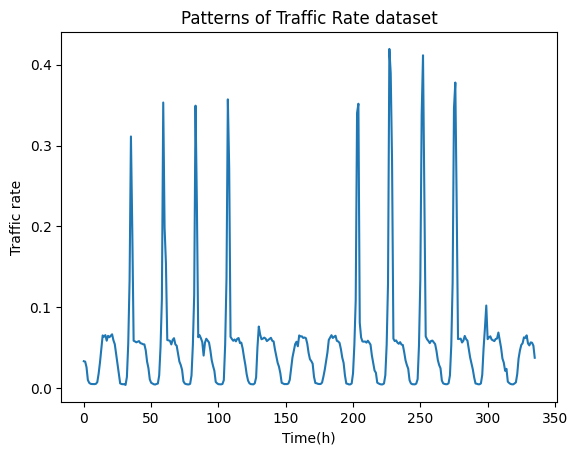

In [20]:
plt.plot(training_values[:168*2,0])
plt.title('Patterns of Traffic Rate dataset')
plt.xlabel('Time(h)')
plt.ylabel('Traffic rate')

In [21]:
num_series

70

In [22]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,852,853,854,855,856,857,858,859,860,861
14036,0.0393,0.0381,0.0883,0.0522,0.0176,0.0353,0.0391,0.0612,0.0577,0.0354,...,0.0060,0.0162,0.0218,0.0391,0.0178,0.0230,0.0241,0.0256,0.0345,0.0263
14037,0.0187,0.0269,0.0541,0.0471,0.0123,0.0218,0.0282,0.0477,0.0479,0.0247,...,0.0042,0.0085,0.0155,0.0303,0.0140,0.0170,0.0186,0.0200,0.0202,0.0192
14038,0.0048,0.0167,0.0327,0.0347,0.0063,0.0134,0.0179,0.0315,0.0351,0.0129,...,0.0027,0.0038,0.0073,0.0182,0.0084,0.0128,0.0103,0.0143,0.0120,0.0138
14039,0.0112,0.0105,0.0193,0.0194,0.0032,0.0108,0.0121,0.0201,0.0245,0.0060,...,0.0024,0.0027,0.0007,0.0098,0.0053,0.0078,0.0061,0.0084,0.0102,0.0085
14040,0.0150,0.0074,0.0130,0.0144,0.0020,0.0096,0.0092,0.0110,0.0177,0.0031,...,0.0010,0.0020,0.0003,0.0073,0.0038,0.0049,0.0042,0.0051,0.0080,0.0051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17539,0.0342,0.0332,0.1378,0.0559,0.0165,0.0386,0.0457,0.0687,0.0716,0.0518,...,0.0139,0.0179,0.0278,0.0280,0.0227,0.0375,0.0142,0.0201,0.0341,0.0429
17540,0.0285,0.0253,0.0542,0.0485,0.0131,0.0331,0.0372,0.0569,0.0669,0.0409,...,0.0116,0.0155,0.0201,0.0267,0.0207,0.0320,0.0122,0.0163,0.0306,0.0363
17541,0.0276,0.0257,0.0551,0.0474,0.0121,0.0326,0.0381,0.0566,0.0675,0.0386,...,0.0109,0.0142,0.0208,0.0252,0.0189,0.0287,0.0123,0.0152,0.0292,0.0325
17542,0.0232,0.0229,0.0496,0.0435,0.0119,0.0297,0.0361,0.0517,0.0598,0.0360,...,0.0092,0.0124,0.0219,0.0215,0.0169,0.0258,0.0096,0.0130,0.0252,0.0279


In [23]:
predicted_values = np.zeros((h_test, dataset.shape[1]))

train_values = training_values[:,:num_series]
test_values = test_data.values[:,:num_series]

# train_values = data_[:, :num_series]
# test_values = test_data_2.values[:,:num_series]

print('Initialization')
preprocess_data, training_set, val_set, yt, yp, yp_lagged, all_yt, all_yp, all_lagged = preprocess_external(train_values,h_val,num_series, train_values, test_values, lag)
# preprocess_data, training_set, val_set, yt, yp, yp_lagged, all_yt, all_yp, all_lagged = preprocess_external(train_values,h_val,num_series, train_values, test_values, lag, all_data= all_data_2)
print('Initialization')

Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_ = fuzzy_external(fuzzy_method, num_series, training_set, num_groups, yp_lagged, lag)

new_mX = mX_lagged_
#Initialization of model

manual_pattern = 7
print('Start')
#Creation a list of rule object. 
list_rules = [rule_object(None,None,None,None,i) for i in range(7)]

list_best_rules = [rule_object(None,None,None,None,i) for i in range(7)]

best_t_mX_lagged_list = [None]*manual_pattern

best_agg_training_list = [None]*manual_pattern

for n_pattern in range(manual_pattern):

    min_error = 300.0

    bres = min_error

    j = 0

    print('='*89)
    print(f'Starting Pattern {n_pattern}')
    print('='*89)
    #Select a sample pattern for our problem. In that case, we apply a manual pattern on dataset
    t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
    t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
    
    t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]

    
    yp1 = deepcopy(yp[t_lagged,:])
    
    yt1 = deepcopy(yt[t_lagged,:])
    
    yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

    in_sample = training_set[t,:]
    #plt.figure()
    #plt.plot(in_sample)
    #plt.show()
    out_sample = val_set[t_val,:]
    
    #Iintial values for prediction
    initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

    #Always checking if initial values are correct by asserting it's target
    #assert (all_yt[yp_lagged.shape[0] + t_val[0],:] == out_sample[0,:]).all(), 'Target mismatch. Verify initial values lag.'

    #print(f'Shape of in-sample is {in_sample.shape[0]}')
    #assert in_sample.shape[0] == h_train//7
    #print(f'Shape of lagged data is {yp_lagged1.shape[0]}')
    #assert yp_lagged1.shape[0] == h_train//manual_pattern
    #print(f'Shape of validation set is {out_sample.shape[0]}')
    #assert out_sample.shape[0] == h_val//manual_pattern
    #data1 = deepcopy(data_[t[len(t)-len(t_lagged):],:])
    #in_sample = data1[:data1.shape[0]-h_prev,:]
    #out_sample = data1[data1.shape[0]-h_prev:,:]
    #ensemble_rules = list_rules[n_pattern].complete_rules 
    #ensemble_prem_terms = list_rules[n_pattern].prem_terms
    #ensemble_antecedents = list_rules[n_pattern].rules

    #Concatenate rules
    for i in range(num_predictors):
        not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
        n_mX = deepcopy(new_mX)
        n_mX[:,:,not_select_subsample] = 0
        model = autoMFIS(diff_series=diff_series,
                         detrend_series=detrend_series,
                         fuzzy_method=fuzzy_method,
                         solve_method='mqr',
                         defuzz_method=defuzz_method, 
                         num_groups = num_groups, 
                         h_prev = h_val, 
                         num_series = num_series,
                         max_rulesize = max_rulesize, 
                         min_activation = min_activation, 
                         lag = lag, 
                         hide_values = False, 
                         form_method = 'nmean', 
                         split_method = 'FCD')

        model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, n_mX)

        try:
            
            complete_rules, prem_terms, rules, agg_training, wd_ = model.train(train_values, 
                                                                               yt=yt1,
                                                                               yp=yp1,
                                                                               yp_lagged=yp_lagged1,
                                                                               in_sample=in_sample,
                                                                               out_sample=out_sample,
                                                                               not_select_subsample=not_select_subsample, 
                                                                               lag_notused=[], 
                                                                               debug=True)



            #complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data_,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = out_sample.shape[0], diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method=defuzz_method,yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample)
            print(f'Predict on validation set - #{i}')
            #Prediction of a single subset
            yt_totest, errors = model.predict(initial_values, 
                                              data=train_values,
                                              in_sample=in_sample,
                                              out_sample=out_sample, 
                                              agg_training=agg_training,
                                              h_prev=out_sample.shape[0],
                                              n_attempt=f'p_{n_pattern}_subsample_{i}',
                                              wd_=wd_
                                              ,ensemble_antecedents=rules,
                                              ensemble_rules=complete_rules, 
                                              filepath=filepath, 
                                              lim=3.0, 
                                              fig_axis=[num_series,1],
                                              ndata=dataset)

            #errors = predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data_,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged1,h_prev=out_sample.shape[0],not_used_lag=not_used_lag,n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])
            print(errors)
            #print(complete_rules)
            '''
            if errors[1,0] < 0.6:
                if ensemble_rules is None:
                    ensemble_rules = complete_rules
                    ensemble_prem_terms = prem_terms
                    ensemble_antecedents = rules
                    #print(ensemble_rules.shape)
                else:
                    ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                    
                    ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                    ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                    #print(ensemble_rules.shape)
                    #print(ensemble_prem_terms.shape)
                #print(ensemble_rules[:,0])
            elif ensemble_rules is None and i == num_predictors - 1:
                ensemble_rules = complete_rules
                ensemble_prem_terms = prem_terms
                ensemble_antecedents = rules
                print('No rules match criteria. Using rules to fill the gap')
            #print('RMSE Errors = {}'.format(errors[0,:]))
            print('RRSE Errors = {}'.format(errors[1,:]))
            #print('Mean RRSE Error = {}'.format(np.mean(errors[1,:])))
            '''
            if errors[1,0] < bres:
                bres = errors[1,0] 
                list_best_rules[n_pattern].complete_rules = deepcopy(complete_rules)
                list_best_rules[n_pattern].prem_terms = deepcopy(prem_terms)
                list_best_rules[n_pattern].rules = deepcopy(rules) 
                list_best_rules[n_pattern].wd_ = deepcopy(wd_)
                best_agg_training_list[n_pattern] = deepcopy(agg_training)
                best_t_mX_lagged_list[n_pattern] = deepcopy(n_mX)

            if errors[1,0] < 0.8:
                if j == 0:
                    print(errors[1,0])
                    ensemble_rules = deepcopy(complete_rules)
                    ensemble_prem_terms = deepcopy(prem_terms)
                    ensemble_antecedents = deepcopy(rules)
                    wd__ = deepcopy(wd_)
                    min_error = errors[1,0]
                    j += 1
                    #print(f'Min error found = {min_error}')
                else:
                    ensemble_rules = np.concatenate((deepcopy(ensemble_rules), deepcopy(complete_rules)))
                
                    ensemble_prem_terms = np.concatenate((deepcopy(ensemble_prem_terms),deepcopy(prem_terms)))
                    ensemble_antecedents = np.concatenate((deepcopy(ensemble_antecedents),deepcopy(rules)))
                    
            elif ensemble_rules is None and i == num_predictors - 1:
                ensemble_rules = deepcopy(complete_rules)
                ensemble_prem_terms = deepcopy(prem_terms)
                ensemble_antecedents = deepcopy(rules)
                print('No rules match criteria. Using rules to fill the gap')


            #print('RRSE Errors = {}'.format(errors[1,:]))
            # if errors[1,0] < min_error:
            #     ensemble_rules = deepcopy(complete_rules)
            #     ensemble_prem_terms = deepcopy(prem_terms)
            #     ensemble_antecedents = deepcopy(rules)
            #     wd__ = deepcopy(wd_)
            #     min_error = errors[1,0]
                #print(f'Min error found = {min_error}')

        except Exception as e:
            print(e)
            pass
    list_rules[n_pattern].complete_rules = deepcopy(ensemble_rules)
    list_rules[n_pattern].prem_terms = deepcopy(ensemble_prem_terms)
    list_rules[n_pattern].rules = deepcopy(ensemble_antecedents)
    list_rules[n_pattern].wd_ = deepcopy(wd__)

# init = in_sample.shape[0]
# for h_p in range(0,h_test,24):

#     rem = h_p % 168

#     k = rem // 24

#     #print(f'Debug only, rem = {rem} and k = {k}')
#     #print('='*89)
#     ensemble_antecedents = list_rules[k].rules
#     ensemble_rules = list_rules[k].complete_rules
#     wd_ = list_rules[k].wd_

#     initial_values = all_lagged[yp_lagged.shape[0]+h_p,:num_series].reshape(1,-1)


#     yt_totest, _ = model.predict(initial_values,
#                                  data=train_values, 
#                                  in_sample = yt, 
#                                  out_sample=out_sample, 
#                                  agg_training=agg_training,
#                                  h_prev=24,
#                                  n_attempt=f'p_subsample_{i}',
#                                  wd_=wd_,
#                                  ensemble_antecedents=ensemble_antecedents,
#                                  ensemble_rules=ensemble_rules, 
#                                  filepath=filepath, 
#                                  lim=min_error, 
#                                  fig_axis=[num_series,2],
#                                  ndata=dataset,
#                                  show=False)

#     #print(k)
#     if (h_p+24 > predicted_values.shape[0]):
#         bb = predicted_values.shape[0] - h_p
#         predicted_values[h_p:h_p+bb,:] = yt_totest[0:bb]
#     else:
#         predicted_values[h_p:h_p+24,:] = yt_totest

predicted_values = np.zeros((h_test, num_series))
init = in_sample.shape[0]
for h_p in range(0,h_test,24):

    rem = h_p % 168

    k = rem // 24

    #print(f'Debug only, rem = {rem} and k = {k}')
    #print('='*89)
    ensemble_antecedents = list_rules[k].rules
    ensemble_rules = list_rules[k].complete_rules
    wd_ = list_rules[k].wd_

    initial_values = all_lagged[yp_lagged.shape[0]+h_p,:].reshape(1,-1)


    yt_totest, _ = model.predict(initial_values, 
                                 data=train_values, 
                                 in_sample = yt, 
                                 out_sample=out_sample, 
                                 agg_training=agg_training,
                                 h_prev=24,
                                 n_attempt=f'p_subsample_{i}',
                                 wd_=wd_,
                                 ensemble_antecedents=ensemble_antecedents,
                                 ensemble_rules=ensemble_rules, 
                                 filepath=filepath, 
                                 lim=min_error, 
                                 fig_axis=[num_series,2],
                                 ndata=dataset,
                                 show=False)

    # print(k)
    if (h_p+24 > predicted_values.shape[0]):
        bb = predicted_values.shape[0] - h_p
        predicted_values[h_p:h_p+bb,:] = yt_totest[0:bb]
    else:
        predicted_values[h_p:h_p+24,:] = yt_totest



Initialization
Initialization
Creating for lag values
Start
Starting Pattern 0
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Reweight
Step 5 - Defuzzification
Predict on validation set - #0
[[0.02233148 0.02900684 0.06413408 0.01910535 0.02356414 0.04250204
  0.05018991 0.04403953 0.03277656 0.06963732 0.0390962  0.01770979
  0.02375069 0.02488506 0.0583945  0.03919115 0.02871361 0.02333938
  0.02606193 0.03805905 0.02275741 0.02921467 0.02272727 0.06420189
  0.07349912 0.03989204 0.03970241 0.01314391 0.01847017 0.0331946
  0.04357554 0.05410977 0.04967743 0.04381798 0.0154691  0.01868231
  0.01116931 0.0537396  0.0106482  0.02275741 0.01983899 0.04428419
  0.02592845 0.01493151 0.00864676 0.05127153 0.02568693 0.03470264
  0.02919953 0.02352953 0.0162941  0.0127314  0.04874198 0.0171908
  0.02315748 0.09172304 0.03652701 0.02304189 0.05776708 0.01599967
  0.03113939 0.023852   0.03722034 0.01643943 0.04497493 0.00871458
  0.02044074 0.01727725 0.0156873  0.07582

In [17]:
predicted_values = np.zeros((h_test, num_series))
init = in_sample.shape[0]
for h_p in range(0,h_test,24):

    rem = h_p % 168

    k = rem // 24

    #print(f'Debug only, rem = {rem} and k = {k}')
    #print('='*89)
    ensemble_antecedents = list_rules[k].rules
    ensemble_rules = list_rules[k].complete_rules
    wd_ = list_rules[k].wd_

    initial_values = all_lagged[yp_lagged.shape[0]+h_p,:].reshape(1,-1)


    yt_totest, _ = model.predict(initial_values, 
                                 data=train_values, 
                                 in_sample = yt, 
                                 out_sample=out_sample, 
                                 agg_training=agg_training,
                                 h_prev=24,
                                 n_attempt=f'p_subsample_{i}',
                                 wd_=wd_,
                                 ensemble_antecedents=ensemble_antecedents,
                                 ensemble_rules=ensemble_rules, 
                                 filepath=filepath, 
                                 lim=min_error, 
                                 fig_axis=[num_series,2],
                                 ndata=dataset,
                                 show=False)

    print(k)
    if (h_p+24 > predicted_values.shape[0]):
        bb = predicted_values.shape[0] - h_p
        predicted_values[h_p:h_p+bb,:] = yt_totest[0:bb]
    else:
        predicted_values[h_p:h_p+24,:] = yt_totest


0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6
0
1
2
3
4
5
6


In [18]:
train_values = training_values[:,:num_series]
test_values = test_data.values[:,:num_series]

print('Initialization')
preprocess_data, training_set, val_set, yt, yp, yp_lagged, all_yt, all_yp, all_lagged = preprocess_external(train_values,h_val,num_series, train_values, test_values, lag)

Initialization


In [19]:
from math import sqrt

F = predicted_values[:2016,:47]
A = test_data.values[:2016,:47]     
num = sqrt(np.sum((F-A)**2))
den = sqrt(np.sum((A-0)**2))
rrse = num/(den+0.0000001)

In [20]:
rrse

0.51973649045331

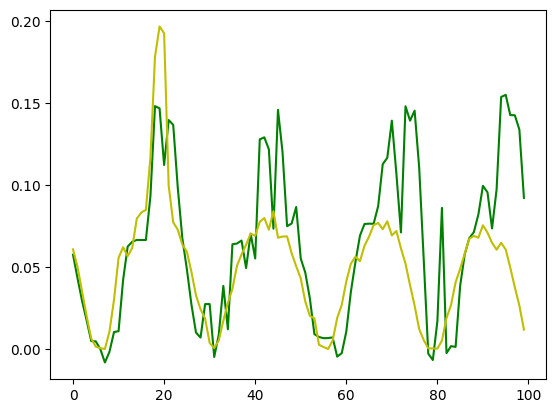

In [21]:
plt.plot(predicted_values[600:700,7],color='g')
plt.plot(test_data.values[600:700,7],color='y')

In [ ]:
all_lagged[yp_lagged.shape[0]+h_p,:num_series].shape

In [24]:
from scipy import fft
from scipy import signal as sig


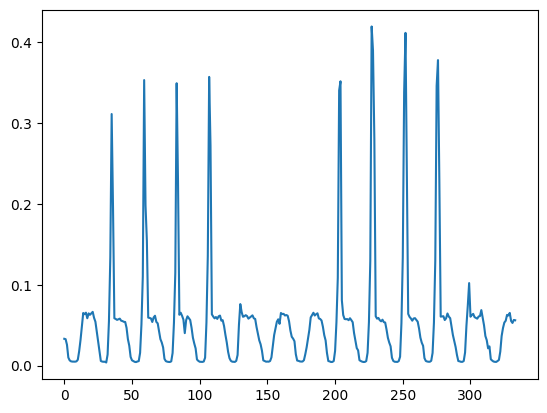

In [22]:
plt.plot(training_values[:334,0])

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ]),
 [Text(-0.05, 0, '−0.05'),
  Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.10000000000000002, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25000000000000006, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30')])

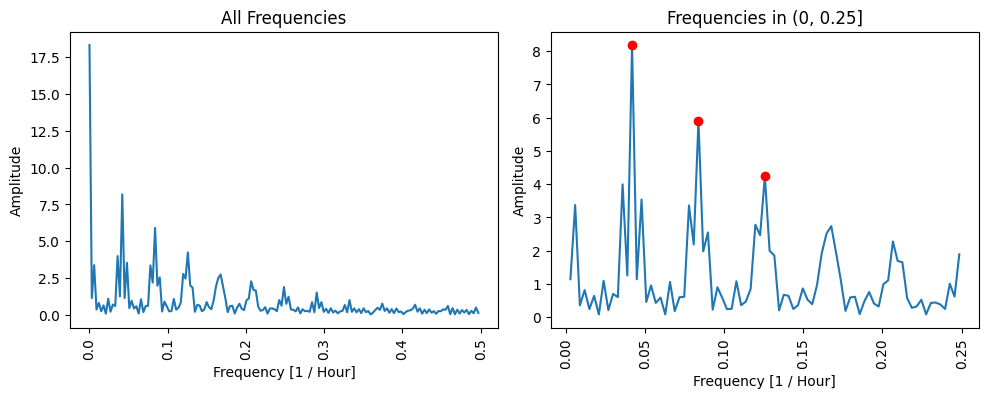

In [25]:
fft_output = fft.fft(training_values[:334,0])
power = np.abs(fft_output)
freq = fft.fftfreq(len(training_values[:334,0]))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='signal')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=3)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90)

In [26]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

,index,freq (1/hour),amplitude,period (days),fft
0,14,0.041916,8.183794,0.994048,-5.957246+5.611212j
1,28,0.083832,5.906198,0.497024,5.793542-1.148062j
2,42,0.125749,4.237904,0.331349,-3.890567+1.680272j


In [ ]:
1/0.041916

In [ ]:
filtered_fft_output = np.array([f if i == 14 or i == 0 else 0 for i, f in enumerate(fft_output)])
filtered_sig = fft.ifft(filtered_fft_output)
n_filtered_sig = fft.ifft(fft_output)

N = 334
plt.plot(np.linspace(0,N,N), training_values[:N,0], linewidth=1, label='Original serie')
plt.plot(np.linspace(0,N,N), filtered_sig[:N].real, linewidth=1, label='Filtered serie')
#plt.plot(np.linspace(0,N,N), n_filtered_sig[:N].real, linewidth=1, label='Non Filtered signal')

plt.legend(loc='upper right')
ax2.set_title('First 5 Days')
plt.grid()
#plt.ylim((-25, 25))
plt.xticks(rotation=90)
plt.xlabel('Time(h)')
plt.ylabel('Values')

In [ ]:
new_values = training_values[:N,0] - filtered_sig[:N].real
fft_output = fft.fft(new_values)
power = np.abs(fft_output)
freq = fft.fftfreq(len(new_values))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='signal')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=3)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()
plt.xticks(rotation=90)

In [ ]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq / 24
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output

In [ ]:
1/0.006

In [ ]:
list_rules[0].complete_rules[a[15:],0]

In [ ]:
35/21

In [ ]:
'''
init = 0
for i,a in enumerate(list_rules):
    try:
        ensemble_rules = a.complete_rules
        ensemble_prem_terms = a.prem_terms
        ensemble_antecedents = a.rules
        
        new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)

        new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms,            ensemble_antecedents)

        wd_, _ = model.reweight_mf(mY_[init:init+ensemble_prem_terms.shape[1],:,:], new_rules, new_prem_terms)
        
        list_rules[i].complete_rules = new_rules
        list_rules[i].prem_terms = new_prem_terms
        list_rules[i].rules = new_antecedents
        list_rules[i].wd_ = wd_

        init += ensemble_prem_terms.shape[1]

    except Exception as e:
        print(e)
'''

In [ ]:
yt_totest[0:4].shape

In [ ]:
n_pattern = 0
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]


yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

#Iintial values for prediction
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0] - 2*168,:].reshape(1,-1)


In [ ]:
from predict import plot_predict

In [ ]:
initial_values = yp_lagged[0,:].reshape(1,-1)


In [ ]:
def ppp(initial_values, lags_used = [], ndata=[''], data=[], out_sample=[],h_prev=0,n_attempt=0,not_used_lag = False, filepath='',lim=0, defuzz_method='cog',fig_axis=[3,2], n_patterns=0, list_rules=None, wd_given=True,offset=0):
        '''
        Function for pattern prediction. 
        \n Important features: 
        \n - n_pattern: Number of seasonal patterns.
        \n - list_rules: list of rules for each pattern.
        '''

        #preprocess_data = Preprocess(data,h_prev=h_prev,num_series=num_series)
        
        #in_sample, out_sample = preprocess_data.split_data()
        
        #yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = in_sample, lag = lag)


        defuzz = Defuzzification(model.mf_params,num_series)

        yp_totest = initial_values
        yt_totest = np.zeros((h_prev,num_series))

        for h_p in range(h_prev):
            #print('='*89)
            #Select which ruleset use now.

            rem = h_p % 168

            k = (rem + offset) // 24
            k = k % 7

            #print(f'Debug only, rem = {rem} and k = {k}')
            #print('='*89)
            ensemble_antecedents = list_rules[k].rules
            ensemble_rules = list_rules[k].complete_rules

            #If weight matrix is not given, just fill with ones.
            if not wd_given:
                wd_ = np.ones((ensemble_rules.shape[0], num_groups, ensemble_rules.shape[1]))
            else:
                wd_ = list_rules[k].wd_



            #print(f'Shape of ensemble rules is {ensemble_rules.shape}')

            mX_values_in = np.zeros((1,model.mf_params.shape[0],yp_totest.shape[1]))
            antecedents_activated = []
            it = 0
            for i in range(num_series):
                mf_params = model.mf_params[:,i]
                for j in range(lag):

                    mX, _ = model.Fuzzify.fuzzify(np.array([yp_totest[0,i*lag+j]]),mf_params,num_groups=num_groups)
                    mX_values_in[:,:,i*lag+j] = mX


                    idx_nonzero = np.where(mX[0,:] > 0)
                    idx_nonzero = idx_nonzero[0]

                    if not_used_lag:
                        for k in range(idx_nonzero.shape[0]):
                            if j in lags_used[i]:
                                antecedents_activated.append((it,idx_nonzero[k]))
                            else:
                                pass
                        it += 1
                    
                    else:
                        for k in range(idx_nonzero.shape[0]):
                            antecedents_activated.append((i*lag+j,idx_nonzero[k]))

            '''
            if not_used_lag:
                mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


            prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
            '''
            rules_idx = []
            check_idx = 0
            
            #Checking for every rule in dataset if it's activated
            #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
            for n_rule in ensemble_antecedents:
                #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
                if test(n_rule,antecedents_activated):
                    rules_idx.append(check_idx)
                check_idx += 1
                
            prem_activated = np.zeros((ensemble_antecedents.shape[0],))
            for i in rules_idx:
                prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
            
            agg_test = np.zeros((wd_.shape))
            for i in range(num_series):
                for j in rules_idx:
                    rule = ensemble_rules[j,i]
                    consequent = rule[-1]
                    agg_test[j,consequent[1],i] = prem_activated[j,]
                    
                    
            weight_agg = np.multiply(agg_test,wd_)
            weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))

            for i in range(weight_.shape[1]):
                weight_[:,i] = weight_agg[:,:,i].max(axis=0)

            w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
            
            #Defuzzification in fact
            y_pred = defuzz.run(defuzz_method,w_todefuzz,show=False)
            
            #Store predicted value into yt_totest.
            yt_totest[h_p,:] = y_pred
            
            #Last step, we use the predicted output to compose input data.
            y_temp = np.zeros(yp_totest.shape)
            assert y_temp.shape == yp_totest.shape
            y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
            for ii in range(num_series):
                #print(yp_totest[0,ii*lag])
                #print(y_pred[0][ii])
                #yp_totest[0,ii*lag] = y_pred[0][ii]
                y_temp[0,ii*lag] = y_pred[0][ii]
                #print(yp_totest[0,yp_totest.shape[1]-1])
            yp_totest = y_temp

        k = 1
        for i in range(num_series):
            plt.subplot(fig_axis[0],fig_axis[1],k)
            plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
            plt.plot(yt_totest[:,i],color='blue')
            plt.plot(out_sample[:,i],color='red')
            plt.legend(['Predicted','Target'])
            plt.xlabel('Time(h)',fontsize=15)
            plt.ylabel('Value',fontsize=15)
            k += 1
    


        errors = plot_predict(lim=500,yt_totest=yt_totest,num_series=num_series,data=data,out_sample=out_sample,trends=[],ndata=ndata,filename='{}/Outsample {}'.format(filepath,n_attempt), fig_axis=fig_axis)
        return errors, yt_totest

In [ ]:
data_ = training_values[:,0:1]
preprocess_data = Preprocess(data_,h_prev=h_val,num_series=num_series, lag=lag)
training_set, val_set = preprocess_data.split_data()
yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = training_set, lag = lag)

#For all set. This will be useful for initial values of prediction
all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = data_, lag = lag)

In [ ]:
initial_values = all_lagged[0,:].reshape(1,-1)

In [ ]:
errors1, yt_totest1 = ppp(initial_values, ndata=dataset, data=data_, out_sample=yt,h_prev=yt.shape[0],n_attempt='_predict', filepath='traffic',lim=0, defuzz_method=defuzz_method,fig_axis=[1,1], n_patterns=7, list_rules=list_rules,offset=2)

In [ ]:
import pickle

with open('traffic.rules','wb') as traffic_rules:
    pickle.dump(list_rules, traffic_rules)

In [ ]:
(yt_totest.shape[0]-166)/168

In [ ]:
errors1

In [ ]:
#with open('best_list.rules','rb') as read_file:

    #blah = pickle.load(read_file)
    #print(blah.shape)

In [ ]:
st += yt_totest1

In [ ]:
plt.plot(yt)
plt.plot(st/5)
print(rrse(st/5,yt))

In [ ]:
#initial_values = all_lagged[yp_lagged.shape[0]-168*2-1,:].reshape(1,-1)
#initial_values = all_lagged[yp_lagged.shape[0],:].reshape(1,-1)

test_values = test_data.values
#test_set = test_values[:,[0, 61, 147, 241]]
test_set = test_values[:,0:1]

errors1 = model.predict_pattern(initial_values, ndata=dataset, data=data_, out_sample=yt[2:,:],mf_params_=mf_params_,h_prev=yt.shape[0]-2,n_attempt='_predict', filepath='traffic',lim=0, defuzz_method=defuzz_method,fig_axis=[1,1], n_patterns=7, list_rules=list_rules)

print(errors1[1,:])

In [ ]:
def pp(initial_values, lags_used = [], ndata=[''], data=[], in_sample=[], out_sample=[], agg_training=None,h_prev=0,n_attempt=0,wd_=[],ensemble_antecedents=[],ensemble_rules=[],not_used_lag = False, filepath='',lim=0, fig_axis=[3,2]):
    '''
    Module to time series forecasting. It uses multi-stepping in order to evaluate the model.
    INPUTS:
    \n - Fuzzyfy: Object containing informations about Fuzzification.
    \n - lags_used: If not_used_lags is true, masks series that isn't in list.
    \n - num_groups: Number of fuzzy sets.
    \n - ndata: name of data (e.g. column header)
    \n - data: data of the problem
    \n - in_sample: in_sample set of data
    \n - out_sample: out_sample set of data
    \n - lag:
    \n - mf_params: Membership function parameters
    \n - agg_training: Aggregation terms in training set. Used to simplify deffuzification of training set.
    \n - yp_lagged
    \n - h_prev:
    #TODO - Continue this list

    VARIABLES:
    \n - y_predict_: Training set prediction
    \n - yp_totest: Input pattern to evaluate prediction
    \n - yt_totest: Output data, for each horizon and serie.
    '''
    

    print(f'Shape of ensemble rules is {ensemble_rules.shape}')


    defuzz = Defuzzification(model.mf_params,num_series)
    if agg_training is not None:
        y_predict_ = defuzz.run(defuzz_method,agg_training)

    yp_totest = initial_values
    yt_totest = np.zeros((h_prev,num_series))

    #Prediction - Multi-step
    for h_p in range(h_prev):

        #Check activated terms.
        mX_values_in = np.zeros((1,model.mf_params.shape[0],yp_totest.shape[1]))

        antecedents_activated = []
        it = 0
        for i in range(num_series):
            mf_params = model.mf_params[:,i]
            for j in range(lag):

                mX, _ = Fuzzyfy.fuzzify(np.array([yp_totest[0,i*lag+j]]),mf_params,num_groups=num_groups)
                mX_values_in[:,:,i*lag+j] = mX


                idx_nonzero = np.where(mX[0,:] > 0)
                idx_nonzero = idx_nonzero[0]

                if not_used_lag:
                    for k in range(idx_nonzero.shape[0]):
                        if j in lags_used[i]:
                            antecedents_activated.append((it,idx_nonzero[k]))
                        else:
                            pass
                    it += 1
                
                else:
                    for k in range(idx_nonzero.shape[0]):
                        antecedents_activated.append((i*lag+j,idx_nonzero[k]))

        '''
        if not_used_lag:
            mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


        prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
        '''
        rules_idx = []
        check_idx = 0
        #Checking for every rule in dataset if it's activated
        #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
        for n_rule in ensemble_antecedents:
            #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
            if test(n_rule,antecedents_activated):
                rules_idx.append(check_idx)
            check_idx += 1
            
        prem_activated = np.zeros((ensemble_antecedents.shape[0],))
        for i in rules_idx:
            prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
        
        agg_test = np.zeros((wd_.shape))
        for i in range(num_series):
            for j in rules_idx:
                rule = ensemble_rules[j,i]
                consequent = rule[-1]
                agg_test[j,consequent[1],i] = prem_activated[j,]
                

        weight_agg = np.multiply(agg_test,wd_)
        weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))
        for i in range(weight_.shape[1]):
            weight_[:,i] = weight_agg[:,:,i].max(axis=0)

        w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
        
        #Defuzzification in fact
        y_pred = defuzz.run(defuzz_method,w_todefuzz,show=False)
        
        #Store predicted value into yt_totest.
        yt_totest[h_p,:] = y_pred
        
        #Last step, we use the predicted output to compose input data.
        y_temp = np.zeros(yp_totest.shape)
        assert y_temp.shape == yp_totest.shape
        y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
        for ii in range(num_series):
            #print(yp_totest[0,ii*lag])
            #print(y_pred[0][ii])
            #yp_totest[0,ii*lag] = y_pred[0][ii]
            y_temp[0,ii*lag] = y_pred[0][ii]
            #print(yp_totest[0,yp_totest.shape[1]-1])
        yp_totest = y_temp

    k = 1
    for i in range(num_series):
        plt.subplot(fig_axis[0],fig_axis[1],k)
        plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
        plt.plot(yt_totest[:,i],color='blue')
        plt.plot(out_sample[:,i],color='red')
        plt.legend(['Predicted','Target'])
        plt.xlabel('Time(h)',fontsize=15)
        plt.ylabel('Value',fontsize=15)
        print(rrse(yt_totest[:,i],out_sample[:,i]))
        k += 1

    return yp_totest, yt_totest

In [ ]:
from metrics import rrse
from defuzzification import Defuzzification

In [ ]:
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0] - 2*168,:].reshape(1,-1)

In [ ]:
weekend_wd = list_rules[6].wd_
weekend_antecedents = list_rules[6].rules
weekend_rules = list_rules[6].complete_rules
out_sample = test_set[:24,:].reshape(-1,1)

new_values__, new_results__ = pp(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=weekend_wd,ensemble_antecedents=weekend_antecedents,ensemble_rules=weekend_rules, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
weekend_wd = list_rules[0].wd_
weekend_antecedents = list_rules[0].rules
weekend_rules = list_rules[0].complete_rules
out_sample = test_set[:24,:].reshape(-1,1)

new_values_, new_results_ = pp(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=weekend_wd,ensemble_antecedents=weekend_antecedents,ensemble_rules=weekend_rules, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
mean_weekend = (new_results_ + new_results__)/2
mean_initial_values = (new_values_ + new_values__)/2
plt.figure()
plt.plot(mean_weekend)
plt.plot(out_sample)
print(rrse(mean_weekend,out_sample))

In [ ]:
n_pattern = 0
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]


yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

#Iintial values for prediction
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0] - 2*168,:].reshape(1,-1)





weekday_wd = list_rules[n_pattern].wd_
weekday_antecedents = list_rules[n_pattern].rules
weekday_rules = list_rules[n_pattern].complete_rules
#out_sample = test_set[48:72,:].reshape(-1,1)
new_values___, new_results___ = pp(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=weekday_wd,ensemble_antecedents=weekday_antecedents,ensemble_rules=weekday_rules, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
store_values = new_results___

In [ ]:
store_values = np.concatenate((store_values,new_results___))

In [ ]:
plt.plot(store_values[24:])
plt.plot(val_set)
plt.legend(('Predicted','Actual'))
plt.title('Sample of validation set')
plt.xlabel('Timestamp(h)')
plt.ylabel('Traffic rate')
rrse(store_values[24:],val_set)

In [ ]:
#errors = predict_pattern(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data_, lag = lag, mf_params_=mf_params_,num_series=num_series,h_prev=h_test,not_used_lag=not_used_lag,n_attempt=f'_predict_',wd_=wd_,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2], n_patterns=n_pattern, list_rules = list_rules)


In [ ]:
'''
k = 2
t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24*k,24*(k+1))]
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
yp1 = deepcopy(yp[t_lagged,:])
yt1 = deepcopy(yt[t_lagged,:])
yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

data1 = deepcopy(data[t[len(t)-len(t_lagged):],:])
in_sample = data1[:data1.shape[0]-h_prev,:]
out_sample = data1[data1.shape[0]-h_prev:,:]

print(len(t_lagged))
'''

In [ ]:
#ll = [rule_object(None,None,None,k) for k in range(7)]

In [ ]:
weekend_antecedents = 
weekend_rules = 
weekend_wd = 

In [ ]:
plt.plot(np.arange(0,training_set.shape[0]),training_set[:,0],label='Train')
plt.plot(np.arange(training_set.shape[0],training_set.shape[0]+val_set.shape[0]),val_set[:,0],color='r',label='Validation')
plt.plot(np.arange(training_set.shape[0]+val_set.shape[0], training_set.shape[0]+val_set.shape[0] + test_set.shape[0]),test_set[:,0],label='Test')
plt.xlabel('Time')
plt.ylabel('Traffic rate')
plt.title('Data split')
plt.legend(['Train','Validation','Test'])

In [ ]:
a = dataset.corr()

In [ ]:
np.sort(a[0].values)[-5:]

In [ ]:
b = a[0].values

In [ ]:
for i in np.sort(a[0].values)[-5:]:
    print(np.where(np.isclose(b,i)))

In [ ]:
from defuzzification import Defuzzification
from metrics import rrse

In [ ]:
h_prev = h_test
wd_given = True
fig_axis = [2,2]
ndata = dataset

out_sample = test_set

initial_values = all_lagged[yp_lagged.shape[0],:].reshape(1,-1)

defuzz = Defuzzification(mf_params_,num_series)

yp_totest = initial_values
yt_totest = np.zeros((h_prev,num_series))

for h_p in range(h_prev):
    print('='*89)
    #Select which ruleset use now.

    rem = h_p % 168

    k = rem // 24

    print(f'Debug only, rem = {rem} and k = {k}')
    print('='*89)
    ensemble_antecedents = list_rules[k].rules
    ensemble_rules = list_rules[k].complete_rules

    #If weight matrix is not given, just fill with ones.
    if not wd_given:
        wd_ = np.ones((ensemble_rules.shape[0], num_groups, ensemble_rules.shape[1]))
        print('Weights not given')
    else:
        wd_ = list_rules[k].wd_



    print(f'Shape of ensemble rules is {ensemble_rules.shape}')

    mX_values_in = np.zeros((1,mf_params_.shape[0],yp_totest.shape[1]))
    antecedents_activated = []
    it = 0
    for i in range(num_series):
        mf_params = mf_params_[:,i]
        for j in range(lag):

            mX, _ = Fuzzyfy.fuzzify(np.array([yp_totest[0,i*lag+j]]),mf_params,num_groups=num_groups)
            mX_values_in[:,:,i*lag+j] = mX


            idx_nonzero = np.where(mX[0,:] > 0)
            idx_nonzero = idx_nonzero[0]

            if not_used_lag:
                for k in range(idx_nonzero.shape[0]):
                    if j in lags_used[i]:
                        antecedents_activated.append((it,idx_nonzero[k]))
                    else:
                        pass
                it += 1
            
            else:
                for k in range(idx_nonzero.shape[0]):
                    antecedents_activated.append((i*lag+j,idx_nonzero[k]))

    '''
    if not_used_lag:
        mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


    prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
    '''
    rules_idx = []
    check_idx = 0
    
    #Checking for every rule in dataset if it's activated
    #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
    for n_rule in ensemble_antecedents:
        #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
        if test(n_rule,antecedents_activated):
            rules_idx.append(check_idx)
        check_idx += 1
        
    prem_activated = np.zeros((ensemble_antecedents.shape[0],))
    for i in rules_idx:
        prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
    
    agg_test = np.zeros((wd_.shape))
    for i in range(num_series):
        for j in rules_idx:
            rule = ensemble_rules[j,i]
            consequent = rule[-1]
            agg_test[j,consequent[1],i] = prem_activated[j,]
            
            
    weight_agg = np.multiply(agg_test,wd_)
    weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))

    for i in range(weight_.shape[1]):
        weight_[:,i] = weight_agg[:,:,i].max(axis=0)

    w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
    
    #Defuzzification in fact
    y_pred = defuzz.run(defuzz_method,w_todefuzz,show=False)
    
    #Store predicted value into yt_totest.
    yt_totest[h_p,:] = y_pred
    
    #Last step, we use the predicted output to compose input data.
    y_temp = np.zeros(yp_totest.shape)
    assert y_temp.shape == yp_totest.shape
    y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
    for ii in range(num_series):
        #print(yp_totest[0,ii*lag])
        #print(y_pred[0][ii])
        #yp_totest[0,ii*lag] = y_pred[0][ii]
        y_temp[0,ii*lag] = y_pred[0][ii]
        #print(yp_totest[0,yp_totest.shape[1]-1])
    yp_totest = y_temp

k = 1
for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
    plt.plot(yt_totest[:,i],color='blue')
    plt.plot(out_sample[:,i],color='red')
    plt.legend(['Predicted','Target'])
    plt.xlabel('Time(h)',fontsize=15)
    plt.ylabel('Value',fontsize=15)
    print(rrse(yt_totest[:,i],out_sample[:,i]))
    k += 1


In [ ]:
prem_activated.shape

In [ ]:
a = yt_totest

In [ ]:
np.mean(out_sample[:,0])

In [ ]:
yp_totest.shape

In [ ]:
y_temp = np.zeros(yp_totest.shape)
assert y_temp.shape == yp_totest.shape
y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]

In [ ]:
from math import sqrt
num = np.zeros((out_sample.shape))
den = np.zeros((out_sample.shape))
for k in range(num_series):
    for j in range(out_sample.shape[0]):
        A = out_sample[j,k]
        F = yt_totest[j,k]
        num[j,k] = sqrt(np.sum((F-A)**2))
        den[j,k] = sqrt(np.sum((A-np.mean(out_sample[:,k]))**2))

In [ ]:
for i in range(num_series):
    plt.figure()
    plt.plot(num[:,i], color='red')
    plt.plot(den[:,i], color='green')
    plt.plot(num[:,i]/den[:,i], color='orange')
    print(np.sum(num[:,i])/np.sum(den[:,i]))

In [ ]:
b = 7
plt.plot(yt_totest[168*b:168*(b+1),0])
plt.plot(out_sample[168*b:168*(b+1),0])

In [ ]:
n_pattern = 4
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]

yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

wd_ = list_rules[n_pattern].wd_
rules = list_rules[n_pattern].rules 
complete_rules = list_rules[n_pattern].complete_rules 
print(f'Shape of ensemble rules is {complete_rules.shape}')

#Iintial values for prediction
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

errors = model.predict(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'TEST_p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[2,2],ndata=dataset)

#errors = model.predict(initial_values, data=data_,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'TEST_p_{n_pattern}_subsample_{i}',wd_=list_rules[n_pattern].wd_,ensemble_antecedents=list_rules[n_pattern].rules,ensemble_rules=list_rules[n_pattern].complete_rules, filepath=filepath, lim=3.0, fig_axis=[2,2],ndata=dataset)

print(errors[1,:])

In [ ]:
h_prev = h_test
wd_given = True
fig_axis = [1,1]
ndata = dataset

n_pattern = 6
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]

yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

wd_ = list_rules[5].wd_
rules = list_rules[5].rules 
complete_rules = list_rules[5].complete_rules 
print(f'Shape of ensemble rules is {complete_rules.shape}')

initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)



defuzz = Defuzzification(mf_params_,num_series)

h_prev = 24

yp_totest = initial_values
yt_totest = np.zeros((h_prev,num_series))


for h_p in range(h_prev):
    print('='*89)
    #Select which ruleset use now.

    rem = h_p % 168

    k = rem // 24

    print(f'Debug only, rem = {rem} and k = {k}')
    print('='*89)
    ensemble_antecedents = rules
    ensemble_rules = complete_rules

    #If weight matrix is not given, just fill with ones.

    print(f'Shape of ensemble rules is {ensemble_rules.shape}')

    mX_values_in = np.zeros((1,mf_params_.shape[0],yp_totest.shape[1]))
    antecedents_activated = []
    it = 0
    for i in range(num_series):
        mf_params = mf_params_[:,i]
        for j in range(lag):

            mX, _ = Fuzzyfy.fuzzify(np.array([yp_totest[0,i*lag+j]]),mf_params,num_groups=num_groups)
            mX_values_in[:,:,i*lag+j] = mX


            idx_nonzero = np.where(mX[0,:] > 0)
            idx_nonzero = idx_nonzero[0]

            if not_used_lag:
                for k in range(idx_nonzero.shape[0]):
                    if j in lags_used[i]:
                        antecedents_activated.append((it,idx_nonzero[k]))
                    else:
                        pass
                it += 1
            
            else:
                for k in range(idx_nonzero.shape[0]):
                    antecedents_activated.append((i*lag+j,idx_nonzero[k]))

    '''
    if not_used_lag:
        mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


    prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
    '''
    rules_idx = []
    check_idx = 0
    
    #Checking for every rule in dataset if it's activated
    #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
    for n_rule in ensemble_antecedents:
        #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
        if test(n_rule,antecedents_activated):
            rules_idx.append(check_idx)
        check_idx += 1
        
    prem_activated = np.zeros((ensemble_antecedents.shape[0],))
    for i in rules_idx:
        prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
    
    agg_test = np.zeros((wd_.shape))
    for i in range(num_series):
        for j in rules_idx:
            rule = ensemble_rules[j,i]
            consequent = rule[-1]
            agg_test[j,consequent[1],i] = prem_activated[j,]
            
            
    weight_agg = np.multiply(agg_test,wd_)
    weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))

    for i in range(weight_.shape[1]):
        weight_[:,i] = weight_agg[:,:,i].max(axis=0)

    w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
    
    #Defuzzification in fact
    y_pred = defuzz.run(defuzz_method,w_todefuzz,show=False)
    
    #Store predicted value into yt_totest.
    yt_totest[h_p,:] = y_pred
    
    #Last step, we use the predicted output to compose input data.
    y_temp = np.zeros(yp_totest.shape)
    assert y_temp.shape == yp_totest.shape
    y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
    for ii in range(num_series):
        #print(yp_totest[0,ii*lag])
        #print(y_pred[0][ii])
        #yp_totest[0,ii*lag] = y_pred[0][ii]
        y_temp[0,ii*lag] = y_pred[0][ii]
        #print(yp_totest[0,yp_totest.shape[1]-1])
    yp_totest = y_temp

k = 1
for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
    plt.plot(yt_totest[:,i],color='blue')
    plt.plot(out_sample[:,i],color='red')
    plt.legend(['Predicted','Target'])
    plt.xlabel('Time(h)',fontsize=15)
    plt.ylabel('Value',fontsize=15)
    print(rrse(yt_totest[:,i],out_sample[:,i]))
    k += 1


In [ ]:
yt_totest.shape

In [ ]:
h_prev = h_test
wd_given = True
fig_axis = [1,1]
ndata = dataset

n_pattern = 4
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]

yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

wd_ = list_rules[2].wd_
rules = list_rules[2].rules 
complete_rules = list_rules[2].complete_rules 
print(f'Shape of ensemble rules is {complete_rules.shape}')

#initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)
initial_values = yp_totest


defuzz = Defuzzification(mf_params_,num_series)

h_prev = 24

yp_totest = initial_values
yt_totest = np.zeros((h_prev,num_series))


for h_p in range(h_prev):
    print('='*89)
    #Select which ruleset use now.

    rem = h_p % 168

    k = rem // 24

    print(f'Debug only, rem = {rem} and k = {k}')
    print('='*89)
    ensemble_antecedents = rules
    ensemble_rules = complete_rules

    #If weight matrix is not given, just fill with ones.

    print(f'Shape of ensemble rules is {ensemble_rules.shape}')

    mX_values_in = np.zeros((1,mf_params_.shape[0],yp_totest.shape[1]))
    antecedents_activated = []
    it = 0
    for i in range(num_series):
        mf_params = mf_params_[:,i]
        for j in range(lag):

            mX, _ = Fuzzyfy.fuzzify(np.array([yp_totest[0,i*lag+j]]),mf_params,num_groups=num_groups)
            mX_values_in[:,:,i*lag+j] = mX


            idx_nonzero = np.where(mX[0,:] > 0)
            idx_nonzero = idx_nonzero[0]

            if not_used_lag:
                for k in range(idx_nonzero.shape[0]):
                    if j in lags_used[i]:
                        antecedents_activated.append((it,idx_nonzero[k]))
                    else:
                        pass
                it += 1
            
            else:
                for k in range(idx_nonzero.shape[0]):
                    antecedents_activated.append((i*lag+j,idx_nonzero[k]))

    '''
    if not_used_lag:
        mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


    prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
    '''
    rules_idx = []
    check_idx = 0
    
    #Checking for every rule in dataset if it's activated
    #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
    for n_rule in ensemble_antecedents:
        #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
        if test(n_rule,antecedents_activated):
            rules_idx.append(check_idx)
        check_idx += 1
        
    prem_activated = np.zeros((ensemble_antecedents.shape[0],))
    for i in rules_idx:
        prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
    
    agg_test = np.zeros((wd_.shape))
    for i in range(num_series):
        for j in rules_idx:
            rule = ensemble_rules[j,i]
            consequent = rule[-1]
            agg_test[j,consequent[1],i] = prem_activated[j,]
            
            
    weight_agg = np.multiply(agg_test,wd_)
    weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))

    for i in range(weight_.shape[1]):
        weight_[:,i] = weight_agg[:,:,i].max(axis=0)

    w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
    
    #Defuzzification in fact
    y_pred = defuzz.run(defuzz_method,w_todefuzz,show=False)
    
    #Store predicted value into yt_totest.
    yt_totest[h_p,:] = y_pred
    
    #Last step, we use the predicted output to compose input data.
    y_temp = np.zeros(yp_totest.shape)
    assert y_temp.shape == yp_totest.shape
    y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
    for ii in range(num_series):
        #print(yp_totest[0,ii*lag])
        #print(y_pred[0][ii])
        #yp_totest[0,ii*lag] = y_pred[0][ii]
        y_temp[0,ii*lag] = y_pred[0][ii]
        #print(yp_totest[0,yp_totest.shape[1]-1])
    yp_totest = y_temp

k = 1
for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
    plt.plot(yt_totest[:,i],color='blue')
    plt.plot(out_sample[:,i],color='red')
    plt.legend(['Predicted','Target'])
    plt.xlabel('Time(h)',fontsize=15)
    plt.ylabel('Value',fontsize=15)
    print(rrse(yt_totest[:,i],out_sample[:,i]))
    k += 1


In [ ]:
#Best for weekdays = list_rules[2]

In [ ]:
import pickle

In [ ]:
with open('best_list.rules','wb') as config_list_rules:
    pickle.dump(list_rules, config_list_rules)

In [ ]:
with open('best_list.rules','wb') as config_list_rules:
    pickle.dump(list_rules, config_list_rules)

with open('best_list.rules','rb') as read_file:

    blah = pickle.load(read_file)
    print(blah.shape)

In [ ]:
n_pattern = 6
min_error = 300.0

print('='*89)
print(f'Starting Pattern {n_pattern}')
print('='*89)
#Select a sample pattern for our problem. In that case, we apply a manual pattern on dataset
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]


yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

#Iintial values for prediction
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

#Always checking if initial values are correct by asserting it's target
assert (all_yt[yp_lagged.shape[0] + t_val[0],:] == out_sample[0,:]).all(), 'Target mismatch. Verify initial values lag.'

print(f'Shape of in-sample is {in_sample.shape[0]}')
#assert in_sample.shape[0] == h_train//7
print(f'Shape of lagged data is {yp_lagged1.shape[0]}')
#assert yp_lagged1.shape[0] == h_train//manual_pattern
print(f'Shape of validation set is {out_sample.shape[0]}')
#assert out_sample.shape[0] == h_val//manual_pattern
#data1 = deepcopy(data_[t[len(t)-len(t_lagged):],:])
#in_sample = data1[:data1.shape[0]-h_prev,:]
#out_sample = data1[data1.shape[0]-h_prev:,:]
#ensemble_rules = list_rules[n_pattern].complete_rules 
#ensemble_prem_terms = list_rules[n_pattern].prem_terms
#ensemble_antecedents = list_rules[n_pattern].rules

#Concatenate rules
for i in range(num_predictors):
    not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
    try:
        
        complete_rules, prem_terms, rules, agg_training, wd_ = model.train(data_, yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample,not_select_subsample=not_select_subsample, lag_notused=[])


        print(f'Predict on validation set - #{i}')
        #Prediction of a single subset
        errors = model.predict(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[2,2],ndata=dataset)


        print('RRSE Errors = {}'.format(errors[1,:]))
        if errors[1,0] < min_error:
            print('-'*89)
            print(f'Best rules found with error = {errors[1,0]}')
            print('-'*89)
            ensemble_rules = deepcopy(complete_rules)
            ensemble_prem_terms = deepcopy(prem_terms)
            ensemble_antecedents = deepcopy(rules)
            wd__ = deepcopy(wd_)
            min_error = errors[1,0]

    except Exception as e:
        print(e)
        pass


In [ ]:
aa = ensemble_rules
bb = ensemble_prem_terms
cc = ensemble_antecedents
dd = wd__


In [ ]:
h_prev = h_test
wd_given = True
fig_axis = [1,1]
ndata = dataset

n_pattern = 0
#t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
#t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

#t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]

#yp1 = deepcopy(yp[t_lagged,:])

#yt1 = deepcopy(yt[t_lagged,:])

#yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

#in_sample = training_set[t,:]
#out_sample = val_set[t_val,:]

wd_ = dd
rules = cc
complete_rules = aa
print(f'Shape of ensemble rules is {complete_rules.shape}')

#initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)



defuzz = Defuzzification(mf_params_,num_series)

h_prev = 24

yp_totest = initial_values
yt_totest = np.zeros((h_prev,num_series))


for h_p in range(h_prev):
    print('='*89)
    #Select which ruleset use now.

    rem = h_p % 168

    k = rem // 24

    print(f'Debug only, rem = {rem} and k = {k}')
    print('='*89)
    ensemble_antecedents = rules
    ensemble_rules = complete_rules

    #If weight matrix is not given, just fill with ones.

    print(f'Shape of ensemble rules is {ensemble_rules.shape}')

    mX_values_in = np.zeros((1,mf_params_.shape[0],yp_totest.shape[1]))
    antecedents_activated = []
    it = 0
    for i in range(num_series):
        mf_params = mf_params_[:,i]
        for j in range(lag):

            mX, _ = Fuzzyfy.fuzzify(np.array([yp_totest[0,i*lag+j]]),mf_params,num_groups=num_groups)
            mX_values_in[:,:,i*lag+j] = mX


            idx_nonzero = np.where(mX[0,:] > 0)
            idx_nonzero = idx_nonzero[0]

            if not_used_lag:
                for k in range(idx_nonzero.shape[0]):
                    if j in lags_used[i]:
                        antecedents_activated.append((it,idx_nonzero[k]))
                    else:
                        pass
                it += 1
            
            else:
                for k in range(idx_nonzero.shape[0]):
                    antecedents_activated.append((i*lag+j,idx_nonzero[k]))

    '''
    if not_used_lag:
        mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


    prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
    '''
    rules_idx = []
    check_idx = 0
    
    #Checking for every rule in dataset if it's activated
    #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
    for n_rule in ensemble_antecedents:
        #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
        if test(n_rule,antecedents_activated):
            rules_idx.append(check_idx)
        check_idx += 1
    print(f'{len(rules_idx)} rules activated')    
    prem_activated = np.zeros((ensemble_antecedents.shape[0],))
    for i in rules_idx:
        prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
    
    agg_test = np.zeros((wd_.shape))
    for i in range(num_series):
        for j in rules_idx:
            rule = ensemble_rules[j,i]
            consequent = rule[-1]
            agg_test[j,consequent[1],i] = prem_activated[j,]
            
            
    weight_agg = np.multiply(agg_test,wd_)
    weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))

    for i in range(weight_.shape[1]):
        weight_[:,i] = weight_agg[:,:,i].max(axis=0)

    w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
    
    #Defuzzification in fact
    y_pred = defuzz.run(defuzz_method,w_todefuzz,show=True)
    
    #Store predicted value into yt_totest.
    yt_totest[h_p,:] = y_pred
    
    #Last step, we use the predicted output to compose input data.
    y_temp = np.zeros(yp_totest.shape)
    assert y_temp.shape == yp_totest.shape
    y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
    for ii in range(num_series):
        #print(yp_totest[0,ii*lag])
        #print(y_pred[0][ii])
        #yp_totest[0,ii*lag] = y_pred[0][ii]
        y_temp[0,ii*lag] = y_pred[0][ii]
        #print(yp_totest[0,yp_totest.shape[1]-1])
    yp_totest = y_temp

k = 1
for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
    plt.plot(yt_totest[:,i],color='blue')
    plt.plot(out_sample[:,i],color='red')
    plt.legend(['Predicted','Target'])
    plt.xlabel('Time(h)',fontsize=15)
    plt.ylabel('Value',fontsize=15)
    print(rrse(yt_totest[:,i],out_sample[:,i]))
    k += 1


In [ ]:
errors = model.predict(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
errors

In [ ]:
def pp(initial_values, lags_used = [], ndata=[''], data=[], in_sample=[], out_sample=[], agg_training=None,h_prev=0,n_attempt=0,wd_=[],ensemble_antecedents=[],ensemble_rules=[],not_used_lag = False, filepath='',lim=0, fig_axis=[3,2]):
    '''
    Module to time series forecasting. It uses multi-stepping in order to evaluate the model.
    INPUTS:
    \n - Fuzzyfy: Object containing informations about Fuzzification.
    \n - lags_used: If not_used_lags is true, masks series that isn't in list.
    \n - num_groups: Number of fuzzy sets.
    \n - ndata: name of data (e.g. column header)
    \n - data: data of the problem
    \n - in_sample: in_sample set of data
    \n - out_sample: out_sample set of data
    \n - lag:
    \n - mf_params: Membership function parameters
    \n - agg_training: Aggregation terms in training set. Used to simplify deffuzification of training set.
    \n - yp_lagged
    \n - h_prev:
    #TODO - Continue this list

    VARIABLES:
    \n - y_predict_: Training set prediction
    \n - yp_totest: Input pattern to evaluate prediction
    \n - yt_totest: Output data, for each horizon and serie.
    '''
    

    print(f'Shape of ensemble rules is {ensemble_rules.shape}')


    defuzz = Defuzzification(model.mf_params_,num_series)
    if agg_training is not None:
        y_predict_ = defuzz.run(defuzz_method,agg_training)

    yp_totest = initial_values
    yt_totest = np.zeros((h_prev,num_series))

    #Prediction - Multi-step
    for h_p in range(h_prev):

        #Check activated terms.
        mX_values_in = np.zeros((1,model.mf_params_.shape[0],yp_totest.shape[1]))

        antecedents_activated = []
        it = 0
        for i in range(num_series):
            mf_params = model.mf_params_[:,i]
            for j in range(lag):

                mX, _ = Fuzzyfy.fuzzify(np.array([yp_totest[0,i*lag+j]]),model.mf_params,num_groups=num_groups)
                mX_values_in[:,:,i*lag+j] = mX


                idx_nonzero = np.where(mX[0,:] > 0)
                idx_nonzero = idx_nonzero[0]

                if not_used_lag:
                    for k in range(idx_nonzero.shape[0]):
                        if j in lags_used[i]:
                            antecedents_activated.append((it,idx_nonzero[k]))
                        else:
                            pass
                    it += 1
                
                else:
                    for k in range(idx_nonzero.shape[0]):
                        antecedents_activated.append((i*lag+j,idx_nonzero[k]))

        '''
        if not_used_lag:
            mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


        prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
        '''
        rules_idx = []
        check_idx = 0
        #Checking for every rule in dataset if it's activated
        #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
        for n_rule in ensemble_antecedents:
            #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
            if test(n_rule,antecedents_activated):
                rules_idx.append(check_idx)
            check_idx += 1
            
        prem_activated = np.zeros((ensemble_antecedents.shape[0],))
        for i in rules_idx:
            prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
        
        agg_test = np.zeros((wd_.shape))
        for i in range(num_series):
            for j in rules_idx:
                rule = ensemble_rules[j,i]
                consequent = rule[-1]
                agg_test[j,consequent[1],i] = prem_activated[j,]
                

        weight_agg = np.multiply(agg_test,wd_)
        weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))
        for i in range(weight_.shape[1]):
            weight_[:,i] = weight_agg[:,:,i].max(axis=0)

        w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
        
        #Defuzzification in fact
        y_pred = defuzz.run(defuzz_method,w_todefuzz,show=False)
        
        #Store predicted value into yt_totest.
        yt_totest[h_p,:] = y_pred
        
        #Last step, we use the predicted output to compose input data.
        y_temp = np.zeros(yp_totest.shape)
        assert y_temp.shape == yp_totest.shape
        y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
        for ii in range(num_series):
            #print(yp_totest[0,ii*lag])
            #print(y_pred[0][ii])
            #yp_totest[0,ii*lag] = y_pred[0][ii]
            y_temp[0,ii*lag] = y_pred[0][ii]
            #print(yp_totest[0,yp_totest.shape[1]-1])
        yp_totest = y_temp

    k = 1
    for i in range(num_series):
        plt.subplot(fig_axis[0],fig_axis[1],k)
        plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
        plt.plot(yt_totest[:,i],color='blue')
        plt.plot(out_sample[:,i],color='red')
        plt.legend(['Predicted','Target'])
        plt.xlabel('Time(h)',fontsize=15)
        plt.ylabel('Value',fontsize=15)
        print(rrse(yt_totest[:,i],out_sample[:,i]))
        k += 1

    return yp_totest, yt_totest

In [ ]:
aslib = initial_values

In [ ]:
new_values, new_results = pp(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=wd__,ensemble_antecedents=ensemble_antecedents,ensemble_rules=ensemble_rules, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
n_pattern = 0
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]


yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

#Iintial values for prediction
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

In [ ]:
wd_ = list_rules[3].wd_
rules = list_rules[3].rules 
complete_rules = list_rules[3].complete_rules 

In [ ]:
new_values_, new_results_ = pp(new_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
n_pattern = 2
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]


yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

In [ ]:
h_prev = h_test
wd_given = True
fig_axis = [1,1]
ndata = dataset

n_pattern = 3
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]

yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

wd_ = list_rules[2].wd_
rules = list_rules[2].rules
complete_rules = list_rules[2].complete_rules
print(f'Shape of ensemble rules is {complete_rules.shape}')

initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)



defuzz = Defuzzification(model.mf_params_,num_series)

h_prev = 24

yp_totest = initial_values
yt_totest = np.zeros((h_prev,num_series))


for h_p in range(h_prev):
    #print('='*89)
    #Select which ruleset use now.

    rem = h_p % 168

    k = rem // 24

    #print(f'Debug only, rem = {rem} and k = {k}')
    #print('='*89)
    ensemble_antecedents = rules
    ensemble_rules = complete_rules

    #If weight matrix is not given, just fill with ones.

    #print(f'Shape of ensemble rules is {ensemble_rules.shape}')

    mX_values_in = np.zeros((1,mf_params_.shape[0],yp_totest.shape[1]))
    antecedents_activated = []
    it = 0
    for i in range(num_series):
        mf_params = model.mf_params_[:,i]
        for j in range(lag):

            mX, _ = Fuzzyfy.fuzzify(np.array([yp_totest[0,i*lag+j]]),mf_params,num_groups=num_groups)
            mX_values_in[:,:,i*lag+j] = mX


            idx_nonzero = np.where(mX[0,:] > 0)
            idx_nonzero = idx_nonzero[0]

            if not_used_lag:
                for k in range(idx_nonzero.shape[0]):
                    if j in lags_used[i]:
                        antecedents_activated.append((it,idx_nonzero[k]))
                    else:
                        pass
                it += 1
            
            else:
                for k in range(idx_nonzero.shape[0]):
                    antecedents_activated.append((i*lag+j,idx_nonzero[k]))

    '''
    if not_used_lag:
        mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


    prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
    '''
    rules_idx = []
    check_idx = 0
    
    #Checking for every rule in dataset if it's activated
    #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
    for n_rule in ensemble_antecedents:
        #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
        if test(n_rule,antecedents_activated):
            rules_idx.append(check_idx)
        check_idx += 1
    #print(f'{len(rules_idx)} rules activated')    
    prem_activated = np.zeros((ensemble_antecedents.shape[0],))
    for i in rules_idx:
        prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
    
    agg_test = np.zeros((wd_.shape))
    for i in range(num_series):
        for j in rules_idx:
            rule = ensemble_rules[j,i]
            consequent = rule[-1]
            agg_test[j,consequent[1],i] = prem_activated[j,]
            
            
    weight_agg = np.multiply(agg_test,wd_)
    weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))

    for i in range(weight_.shape[1]):
        weight_[:,i] = weight_agg[:,:,i].max(axis=0)

    w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
    
    #Defuzzification in fact
    y_pred = defuzz.run(defuzz_method,w_todefuzz,show=False)
    
    #Store predicted value into yt_totest.
    yt_totest[h_p,:] = y_pred
    
    #Last step, we use the predicted output to compose input data.
    y_temp = np.zeros(yp_totest.shape)
    assert y_temp.shape == yp_totest.shape
    y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
    for ii in range(num_series):
        #print(yp_totest[0,ii*lag])
        #print(y_pred[0][ii])
        #yp_totest[0,ii*lag] = y_pred[0][ii]
        y_temp[0,ii*lag] = y_pred[0][ii]
        #print(yp_totest[0,yp_totest.shape[1]-1])
    yp_totest = y_temp

k = 1
for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
    plt.plot(yt_totest[:,i],color='blue')
    plt.plot(out_sample[:,i],color='red')
    plt.legend(['Predicted','Target'])
    plt.xlabel('Time(h)',fontsize=15)
    plt.ylabel('Value',fontsize=15)
    print(rrse(yt_totest[:,i],out_sample[:,i]))
    k += 1


In [ ]:
wd_ = list_rules[4].wd_
rules = list_rules[4].rules
complete_rules = list_rules[4].complete_rules

new_values_, new_results_ = pp(new_values_, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
n_pattern = 6
min_error = 300.0

print('='*89)
print(f'Starting Pattern {n_pattern}')
print('='*89)
#Select a sample pattern for our problem. In that case, we apply a manual pattern on dataset
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]


yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

#Iintial values for prediction
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

#Always checking if initial values are correct by asserting it's target
assert (all_yt[yp_lagged.shape[0] + t_val[0],:] == out_sample[0,:]).all(), 'Target mismatch. Verify initial values lag.'

print(f'Shape of in-sample is {in_sample.shape[0]}')
#assert in_sample.shape[0] == h_train//7
print(f'Shape of lagged data is {yp_lagged1.shape[0]}')
#assert yp_lagged1.shape[0] == h_train//manual_pattern
print(f'Shape of validation set is {out_sample.shape[0]}')
#assert out_sample.shape[0] == h_val//manual_pattern
#data1 = deepcopy(data_[t[len(t)-len(t_lagged):],:])
#in_sample = data1[:data1.shape[0]-h_prev,:]
#out_sample = data1[data1.shape[0]-h_prev:,:]
#ensemble_rules = list_rules[n_pattern].complete_rules 
#ensemble_prem_terms = list_rules[n_pattern].prem_terms
#ensemble_antecedents = list_rules[n_pattern].rules

#Concatenate rules
for i in range(num_predictors):
    not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
    try:
        
        complete_rules, prem_terms, rules, agg_training, wd_ = model.train(data_, yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample,not_select_subsample=not_select_subsample, lag_notused=[])


        print(f'Predict on validation set - #{i}')
        #Prediction of a single subset
        errors = model.predict(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[2,2],ndata=dataset)


        print('RRSE Errors = {}'.format(errors[1,:]))
        if errors[1,0] < min_error:
            print('-'*89)
            print(f'Best rules found with error = {errors[1,0]}')
            print('-'*89)
            weekend_ensemble_rules = deepcopy(complete_rules)
            weekend_ensemble_prem_terms = deepcopy(prem_terms)
            weekend_ensemble_antecedents = deepcopy(rules)
            weekend_wd__ = deepcopy(wd_)
            min_error = errors[1,0]

    except Exception as e:
        print(e)
        pass


In [ ]:
n_pattern = 2
min_error = 300.0

print('='*89)
print(f'Starting Pattern {n_pattern}')
print('='*89)
#Select a sample pattern for our problem. In that case, we apply a manual pattern on dataset
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]


yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

#Iintial values for prediction
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

#Always checking if initial values are correct by asserting it's target
assert (all_yt[yp_lagged.shape[0] + t_val[0],:] == out_sample[0,:]).all(), 'Target mismatch. Verify initial values lag.'

print(f'Shape of in-sample is {in_sample.shape[0]}')
#assert in_sample.shape[0] == h_train//7
print(f'Shape of lagged data is {yp_lagged1.shape[0]}')
#assert yp_lagged1.shape[0] == h_train//manual_pattern
print(f'Shape of validation set is {out_sample.shape[0]}')
#assert out_sample.shape[0] == h_val//manual_pattern
#data1 = deepcopy(data_[t[len(t)-len(t_lagged):],:])
#in_sample = data1[:data1.shape[0]-h_prev,:]
#out_sample = data1[data1.shape[0]-h_prev:,:]
#ensemble_rules = list_rules[n_pattern].complete_rules 
#ensemble_prem_terms = list_rules[n_pattern].prem_terms
#ensemble_antecedents = list_rules[n_pattern].rules

#Concatenate rules
for i in range(num_predictors):
    not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
    try:
        
        complete_rules, prem_terms, rules, agg_training, wd_ = model.train(data_, yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample,not_select_subsample=not_select_subsample, lag_notused=[])


        print(f'Predict on validation set - #{i}')
        #Prediction of a single subset
        errors = model.predict(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[2,2],ndata=dataset)


        print('RRSE Errors = {}'.format(errors[1,:]))
        if errors[1,0] < min_error:
            print('-'*89)
            print(f'Best rules found with error = {errors[1,0]}')
            print('-'*89)
            weekday_ensemble_rules = deepcopy(complete_rules)
            weekday_ensemble_prem_terms = deepcopy(prem_terms)
            weekday_ensemble_antecedents = deepcopy(rules)
            weekday_wd__ = deepcopy(wd_)
            min_error = errors[1,0]

    except Exception as e:
        print(e)
        pass


In [ ]:
new_results.shape

In [ ]:
bac = new_results

In [ ]:
bac = np.concatenate((bac,new_results))

In [ ]:
n_pattern = 1
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]


yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

#Iintial values for prediction
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

In [ ]:
#initial_values = all_lagged[yp_lagged.shape[0]-168,:].reshape(1,-1)


#out_sample = test_set[:24,0].reshape(-1,1)
new_values_, new_results_ = pp(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=weekend_wd__,ensemble_antecedents=weekend_ensemble_antecedents,ensemble_rules=weekend_ensemble_rules, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
k = list_rules[2].wd_
l = list_rules[2].rules
p = list_rules[2].complete_rules
out_sample = test_set[24:48,:].reshape(-1,1)

new_values__, new_results__ = pp(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=k,ensemble_antecedents=l,ensemble_rules=p, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
lag

In [ ]:
wd_ = list_rules[4].wd_
rules = list_rules[4].rules
complete_rules = list_rules[4].complete_rules

new_values_, new_results_ = pp(new_values_, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'AA_p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[1,1],ndata=dataset)

In [ ]:
model.mf_params

In [ ]:
n_pattern = 6
min_error = 300.0

print('='*89)
print(f'Starting Pattern {n_pattern}')
print('='*89)
#Select a sample pattern for our problem. In that case, we apply a manual pattern on dataset
t = [a + n + lag for n in range(0,training_set.shape[0]+1,168) for a in range(24*n_pattern,24*(n_pattern+1)) if a + n + lag < h_train] 
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]

t_val = [a + n for n in range(0,val_set.shape[0],168) for a in range(24*n_pattern,24*(n_pattern+1))]


yp1 = deepcopy(yp[t_lagged,:])

yt1 = deepcopy(yt[t_lagged,:])

yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

in_sample = training_set[t,:]
out_sample = val_set[t_val,:]

#Iintial values for prediction
initial_values = all_lagged[yp_lagged.shape[0] + t_val[0],:].reshape(1,-1)

#Always checking if initial values are correct by asserting it's target
assert (all_yt[yp_lagged.shape[0] + t_val[0],:] == out_sample[0,:]).all(), 'Target mismatch. Verify initial values lag.'

print(f'Shape of in-sample is {in_sample.shape[0]}')
#assert in_sample.shape[0] == h_train//7
print(f'Shape of lagged data is {yp_lagged1.shape[0]}')
#assert yp_lagged1.shape[0] == h_train//manual_pattern
print(f'Shape of validation set is {out_sample.shape[0]}')
#assert out_sample.shape[0] == h_val//manual_pattern
#data1 = deepcopy(data_[t[len(t)-len(t_lagged):],:])
#in_sample = data1[:data1.shape[0]-h_prev,:]
#out_sample = data1[data1.shape[0]-h_prev:,:]
#ensemble_rules = list_rules[n_pattern].complete_rules 
#ensemble_prem_terms = list_rules[n_pattern].prem_terms
#ensemble_antecedents = list_rules[n_pattern].rules

#Concatenate rules
for i in range(num_predictors):
    not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
    try:
        
        complete_rules, prem_terms, rules, agg_training, wd_ = model.train(data_, yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample,not_select_subsample=not_select_subsample, lag_notused=[])


        print(f'Predict on validation set - #{i}')
        #Prediction of a single subset
        errors = model.predict(initial_values, data=data_,in_sample=in_sample,out_sample=out_sample, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=3.0, fig_axis=[2,2],ndata=dataset)


        print('RRSE Errors = {}'.format(errors[1,:]))
        if errors[1,0] < min_error:
            print('-'*89)
            print(f'Best rules found with error = {errors[1,0]}')
            print('-'*89)
            weekend_ensemble_rules = deepcopy(complete_rules)
            weekend_ensemble_prem_terms = deepcopy(prem_terms)
            weekend_ensemble_antecedents = deepcopy(rules)
            weekend_wd__ = deepcopy(wd_)
            min_error = errors[1,0]

    except Exception as e:
        print(e)
        pass


In [ ]:
model.set_fuzzy

In [ ]:
mf_params_.shape